In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow as tf

#tf.config.gpu.set_per_process_memory_fraction(0.6)
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

print(tf.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Set mem gworth to ", str(gpu))
    except RuntimeError as e:
        print(e)

2.3.1
Set mem gworth to  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import pathlib
import datetime, os

#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)


#data_dir = pathlib.Path('./img_source_root')
data_dir = pathlib.Path(r'C:\Users\corsair\.keras\datasets\img_source_root')

#print(dir(data_dir))
#type(data_dir)
#print(data_dir)

In [3]:
import os

print(os.getcwd())

E:\University\11sem\nirs\NeuralNet


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

5031


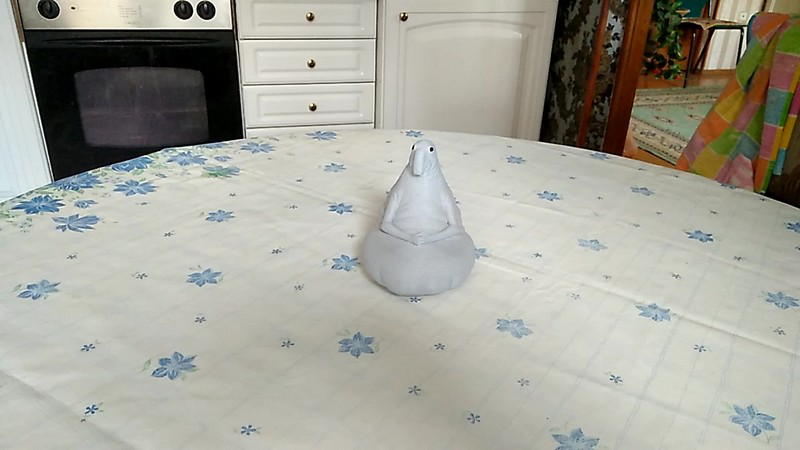

In [5]:
roses = list(data_dir.glob('zdun/*'))
PIL.Image.open(str(roses[0]))

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

In [6]:
batch_size = 32
img_height = 90 #64
img_width = 160 #128

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5031 files belonging to 2 classes.
Using 4025 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5031 files belonging to 2 classes.
Using 1006 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['docking_station', 'zdun']


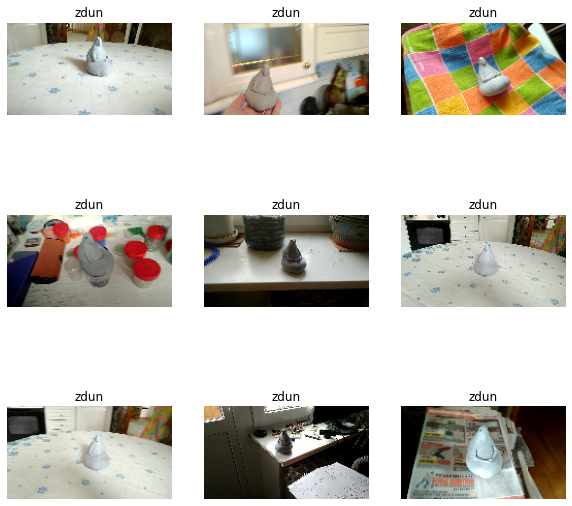

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 90, 160, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [15]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 90, 160, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 90, 160, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 20, 64)        0

In [25]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore',category=FutureWarning)

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    callbacks=[tensorboard]
)

Epoch 1/10
126/126 [==============================] - 2s 13ms/step - loss: 2.4168e-08 - accuracy: 1.0000 - val_loss: 1.4931e-08 - val_accuracy: 1.0000
Epoch 2/10
126/126 [==============================] - 1s 11ms/step - loss: 2.1946e-08 - accuracy: 1.0000 - val_loss: 1.3509e-08 - val_accuracy: 1.0000
Epoch 3/10
126/126 [==============================] - 1s 10ms/step - loss: 1.9784e-08 - accuracy: 1.0000 - val_loss: 1.3509e-08 - val_accuracy: 1.0000
Epoch 4/10
126/126 [==============================] - 1s 11ms/step - loss: 1.8185e-08 - accuracy: 1.0000 - val_loss: 1.3272e-08 - val_accuracy: 1.0000
Epoch 5/10
126/126 [==============================] - 1s 11ms/step - loss: 1.8007e-08 - accuracy: 1.0000 - val_loss: 2.3700e-08 - val_accuracy: 1.0000
Epoch 6/10
126/126 [==============================] - 1s 11ms/step - loss: 1.4690e-08 - accuracy: 1.0000 - val_loss: 1.2324e-08 - val_accuracy: 1.0000
Epoch 7/10
126/126 [==============================] - 1s 11ms/step - loss: 1.4275e-08 - accura

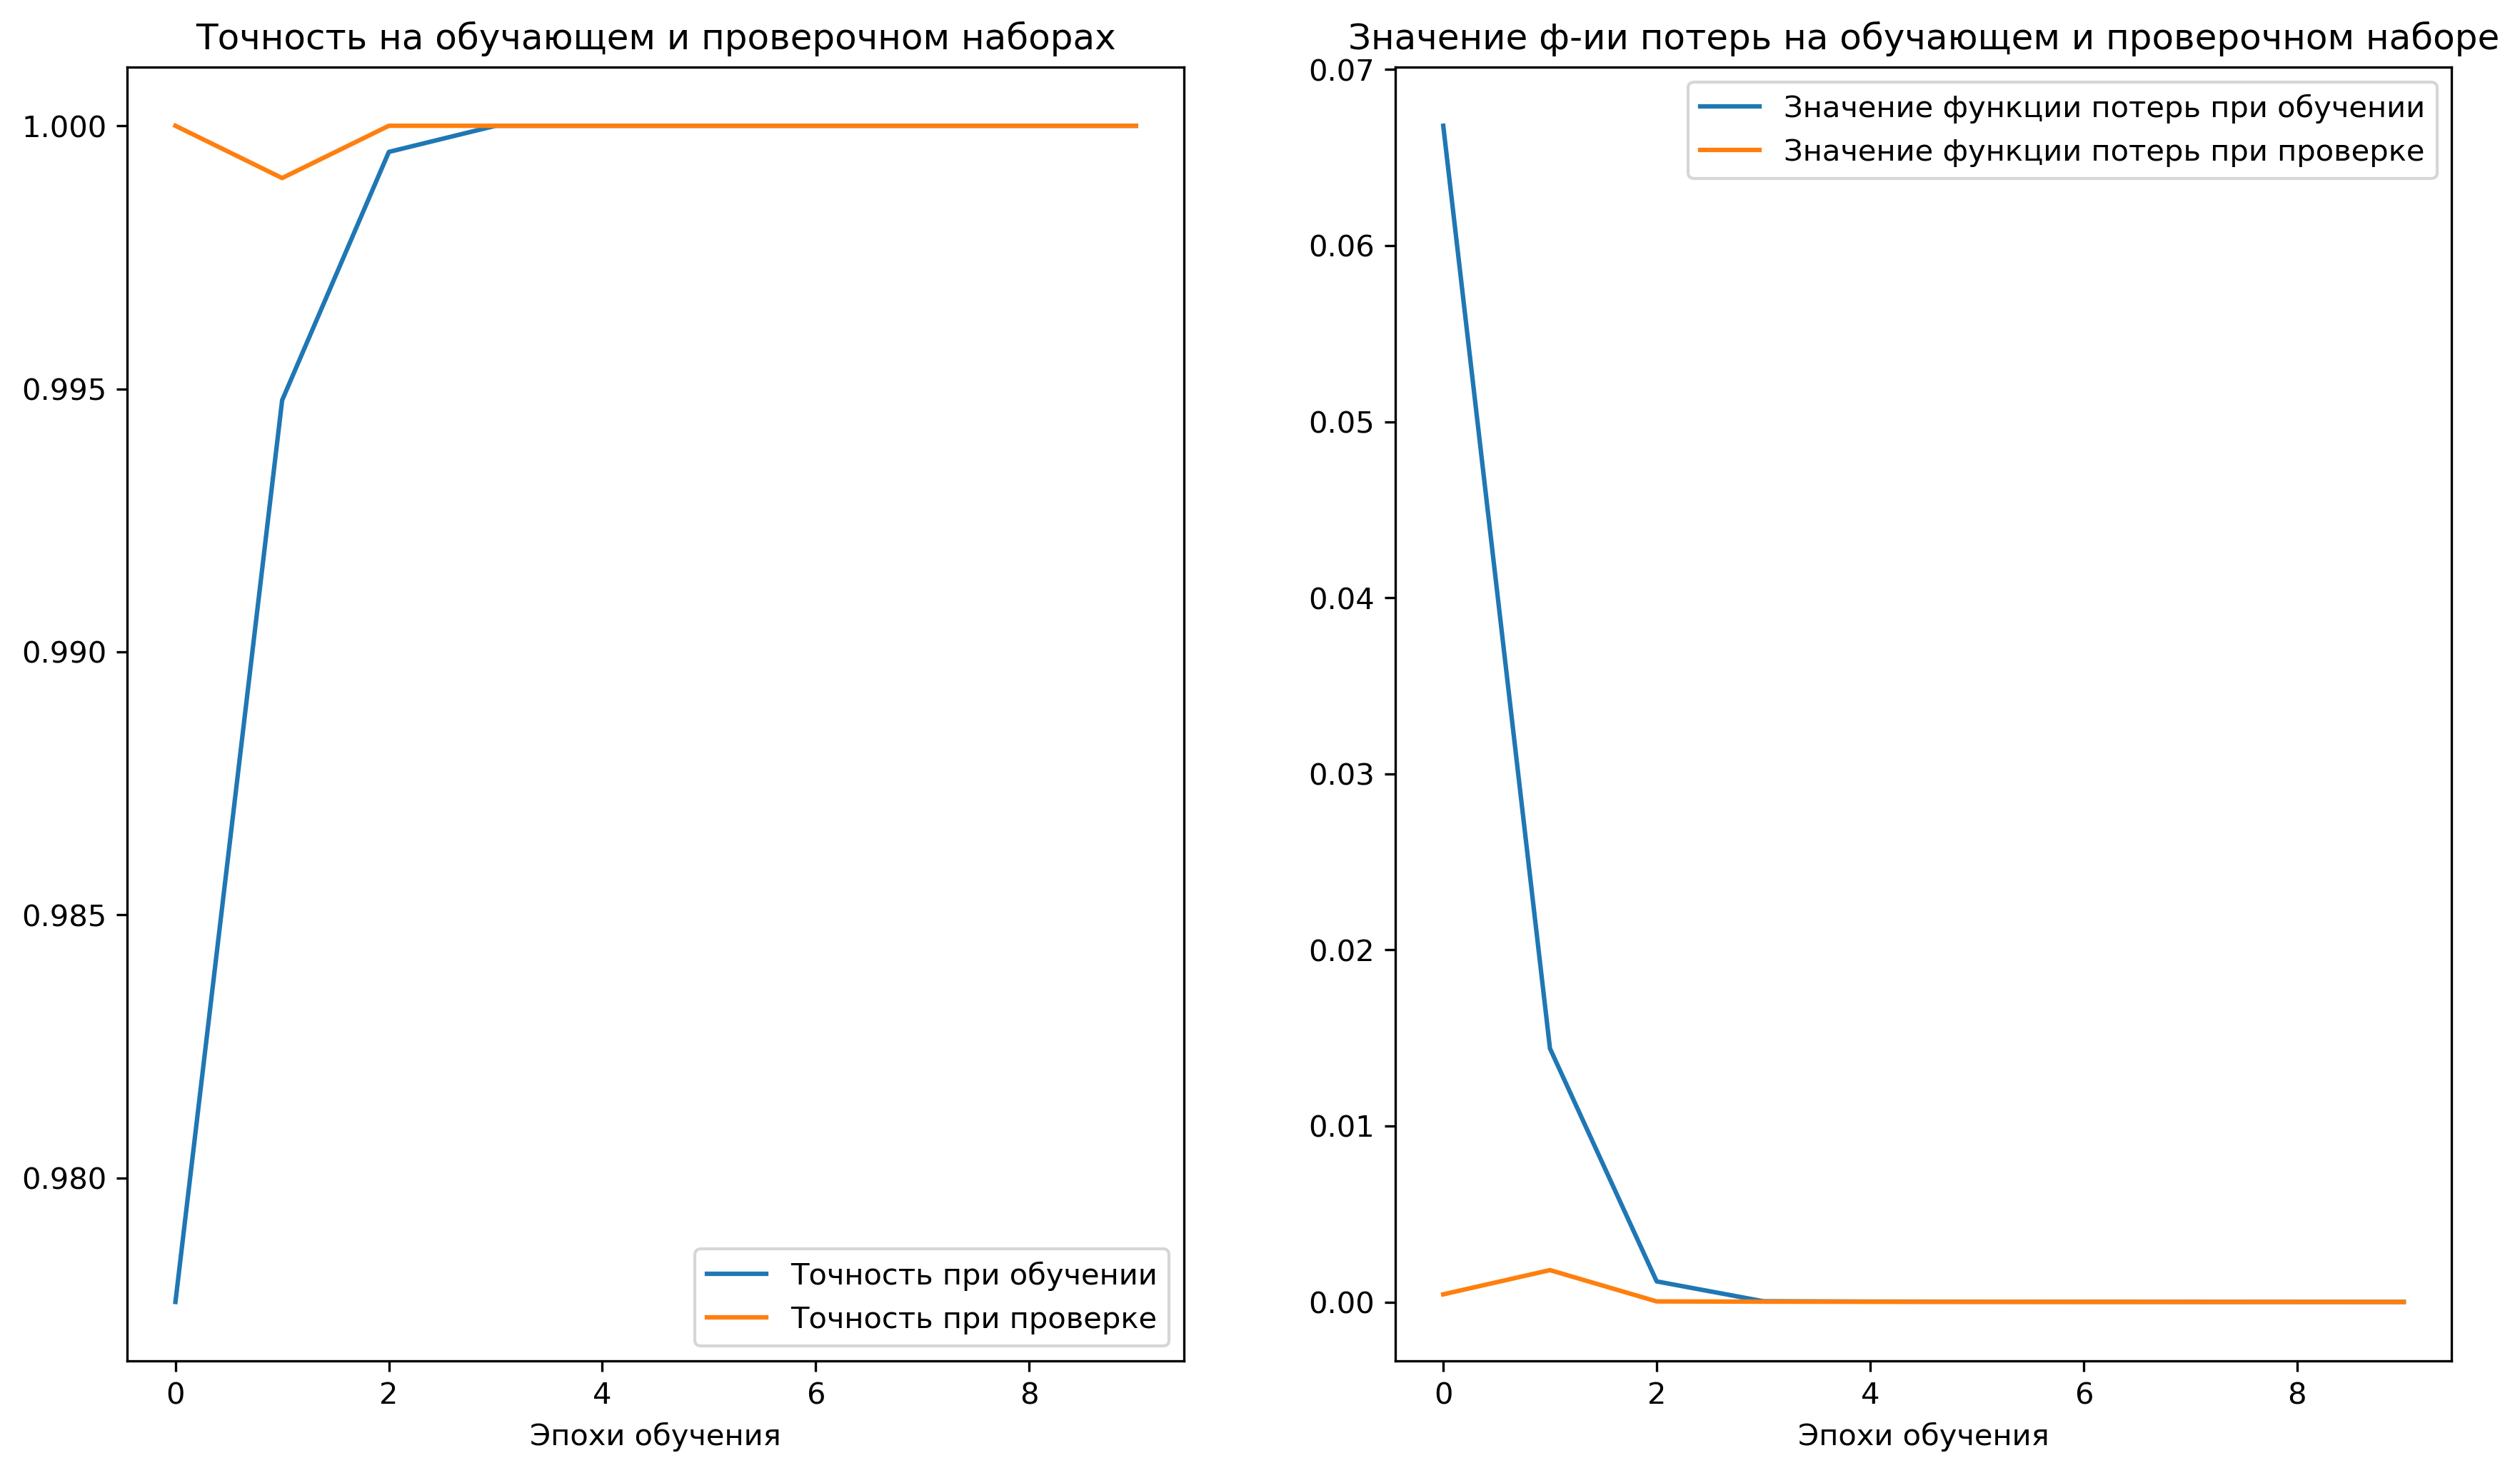

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8), dpi=300)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точность при обучении') #) label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Точность при проверке')# label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Эпохи обучения')
plt.title('Точность на обучающем и проверочном наборах') #'Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Значение функции потерь при обучении')# label='Training Loss')
plt.plot(epochs_range, val_loss, label='Значение функции потерь при проверке')# label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Эпохи обучения')
plt.title('Значение ф-ии потерь на обучающем и проверочном наборе')# 'Training and Validation Loss')
plt.show()

In [21]:
#%load_ext tensorboard
#%tensorboard --logdir logs
#%tensorboard

In [22]:
#sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
#sunflower_path = tf.keras.utils.get_file('E:/University/11sem/nirs/NeuralNet/with663.jpg', origin=sunflower_url)

#img_path = 'E:/University/11sem/nirs/NeuralNet/with663.jpg'
img_path = 'E:/University/11sem/nirs/NeuralNet/pyramid0639.jpg'

img = keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to docking_station with a 100.00 percent confidence.
